In [1]:
############################################################
# NOTEBOOK 2: FAIRNESS MITIGATION (Reweighting + Thresholding)
# Dataset: Heart disease (Excel -> df)
############################################################

############################################################
# STEP 1: SETUP
############################################################
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)

plt.style.use("default")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

print("✓ Tools imported for fairness mitigation")




✓ Tools imported for fairness mitigation


In [7]:
############################################################
# STEP 2: LOAD DATA (adjust path/df name)
############################################################
# If you already have df from Notebook 1, skip this cell.
# Otherwise, read from Excel:
FILE_PATH = "Heart-disease-dataset.xlsx"

df = pd.read_excel(FILE_PATH)

print("✓ File loaded")
print("Shape:", df.shape)
display(df.head())


print("✓ Data load step (skip if df already exists)")




✓ File loaded
Shape: (20, 11)


,Patient ID,Age,Gender,Ethnicity,Cholesterol (mg/dL),Blood Pressure (mmHg),BMI,Smoking,Family History,Hospital Site,Diagnosis (Heart Disease: Yes/No)
0,P1,68,Male,White,250,150/95,30,Yes,Yes,A,Yes
1,P2,72,Male,White,260,155/100,29,Yes,Yes,A,Yes
2,P3,65,Male,White,240,148/92,28,No,Yes,A,Yes
3,P4,59,Male,White,215,142/88,27,No,Yes,A,No
4,P5,55,Female,White,195,135/85,25,No,No,A,No


✓ Data load step (skip if df already exists)


In [8]:
############################################################
# STEP 3: CLEANING + FEATURE ENGINEERING (robust)
############################################################
df_clean = df.copy()

def to_numeric_safe(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    m = re.findall(r"\d+", s)
    return float(m[0]) if m else np.nan

def split_bp(bp):
    if pd.isna(bp):
        return (np.nan, np.nan)
    s = str(bp).strip()
    if "/" not in s:
        return (np.nan, np.nan)
    parts = s.split("/")
    if len(parts) != 2:
        return (np.nan, np.nan)
    try:
        return (float(parts[0]), float(parts[1]))
    except:
        return (np.nan, np.nan)

# Adapt column names here if your file differs
df_clean["Cholesterol_mgdl"] = df_clean["Cholesterol (mg/dL)"].apply(to_numeric_safe)
df_clean["BP_Systolic"] = df_clean["Blood Pressure (mmHg)"].apply(lambda x: split_bp(x)[0])
df_clean["BP_Diastolic"] = df_clean["Blood Pressure (mmHg)"].apply(lambda x: split_bp(x)[1])

target_col = "Diagnosis (Heart Disease: Yes/No)"
df_clean["HeartDiseaseLabel"] = df_clean[target_col].map({"Yes": 1, "No": 0})

# Normalize categoricals
for col in ["Gender", "Ethnicity", "Smoking", "Family History", "Hospital Site"]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype(str).str.strip()

def age_group(age):
    try:
        age = float(age)
    except:
        return np.nan
    if age < 30:
        return "18-29"
    elif age < 45:
        return "30-44"
    elif age < 65:
        return "45-64"
    else:
        return "65+"

df_clean["AgeGroup"] = df_clean["Age"].apply(age_group)

print("✓ Cleaning + engineered features done")
display(df_clean.head())



✓ Cleaning + engineered features done


,Patient ID,Age,Gender,Ethnicity,Cholesterol (mg/dL),Blood Pressure (mmHg),BMI,Smoking,Family History,Hospital Site,Diagnosis (Heart Disease: Yes/No),Cholesterol_mgdl,BP_Systolic,BP_Diastolic,HeartDiseaseLabel,AgeGroup
0,P1,68,Male,White,250,150/95,30,Yes,Yes,A,Yes,250.0,150.0,95.0,1,65+
1,P2,72,Male,White,260,155/100,29,Yes,Yes,A,Yes,260.0,155.0,100.0,1,65+
2,P3,65,Male,White,240,148/92,28,No,Yes,A,Yes,240.0,148.0,92.0,1,65+
3,P4,59,Male,White,215,142/88,27,No,Yes,A,No,215.0,142.0,88.0,0,45-64
4,P5,55,Female,White,195,135/85,25,No,No,A,No,195.0,135.0,85.0,0,45-64


In [9]:

############################################################
# STEP 4: DEFINE FEATURES + TRAIN/TEST SPLIT
############################################################

feature_cols = [
    "Age",
    "BMI",
    "Cholesterol_mgdl",
    "BP_Systolic",
    "BP_Diastolic",
    "Gender",
    "Ethnicity",
    "Smoking",
    "Family History",
    "Hospital Site",
    "AgeGroup"
]

X = df_clean[feature_cols].copy()
y = df_clean["HeartDiseaseLabel"].copy()

# Sensitive attribute for fairness checks
SENSITIVE_COL = "Gender"  # change to "Ethnicity" if you want

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y if y.nunique() > 1 else None
)

# keep group labels aligned to split
g_train = X_train[SENSITIVE_COL].copy()
g_test = X_test[SENSITIVE_COL].copy()

print("✓ Split done")
print("Train:", X_train.shape, "Test:", X_test.shape)
print("Groups (train):")
print(g_train.value_counts())




✓ Split done
Train: (14, 11) Test: (6, 11)
Groups (train):
Gender
Male      8
Female    6
Name: count, dtype: int64


In [10]:
############################################################
# STEP 5: PREPROCESS PIPELINE (Impute + Scale + OneHot)
############################################################
numeric_features = ["Age", "BMI", "Cholesterol_mgdl", "BP_Systolic", "BP_Diastolic"]
categorical_features = ["Gender", "Ethnicity", "Smoking", "Family History", "Hospital Site", "AgeGroup"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)




In [11]:
############################################################
# STEP 6: FAIRNESS METRICS (utility functions)
############################################################
def group_confusion_stats(y_true, y_pred):
    """
    Returns TP, FP, TN, FN and derived rates.
    """
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan  # recall for positive
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
    pr  = tp / (tp + fp) if (tp + fp) > 0 else np.nan  # precision

    return {
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,
        "TPR": tpr, "FPR": fpr, "TNR": tnr, "FNR": fnr, "Precision": pr
    }

def fairness_report(y_true, y_pred, groups, title="FAIRNESS REPORT"):
    """
    Prints group-wise metrics + simple gaps.
    """
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred, "group": groups})

    rows = []
    for g in sorted(df["group"].unique()):
        part = df[df["group"] == g]
        stats = group_confusion_stats(part["y_true"], part["y_pred"])
        stats["Group"] = g
        stats["Support"] = len(part)
        rows.append(stats)

    rep = pd.DataFrame(rows).set_index("Group")
    print(f"\n=== {title} ===")
    display(rep[["Support", "TPR", "FPR", "Precision"]].round(3))

    # simple gap view (max-min)
    gaps = {
        "TPR_gap": float(rep["TPR"].max() - rep["TPR"].min()),
        "FPR_gap": float(rep["FPR"].max() - rep["FPR"].min()),
        "Precision_gap": float(rep["Precision"].max() - rep["Precision"].min())
    }
    print("Gaps (max-min):", {k: round(v, 3) for k, v in gaps.items()})
    return rep, gaps

def plot_gap_bar(gaps_dict, title):
    keys = list(gaps_dict.keys())
    vals = [gaps_dict[k] for k in keys]
    plt.figure(figsize=(7, 4))
    plt.bar(keys, vals)
    plt.title(title)
    plt.ylabel("Gap (max - min)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()




Training baseline...

=== BASELINE PERFORMANCE (Overall) ===
              precision    recall  f1-score   support

           0      0.750     1.000     0.857         3
           1      1.000     0.667     0.800         3

    accuracy                          0.833         6
   macro avg      0.875     0.833     0.829         6
weighted avg      0.875     0.833     0.829         6

ROC-AUC: 1.0


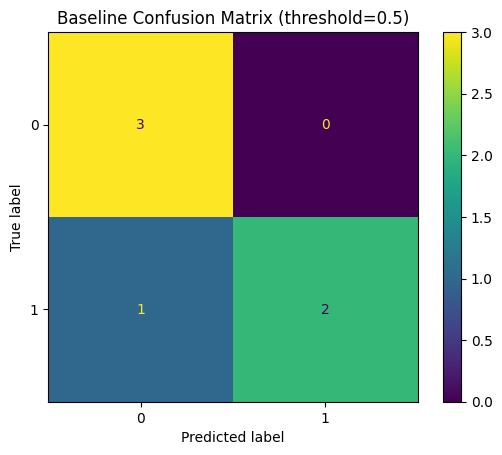


=== BASELINE FAIRNESS by Gender ===


,Support,TPR,FPR,Precision
Group,,,,
Female,4,0.0,0.0,NaN
Male,2,1.0,NaN,1.0


Gaps (max-min): {'TPR_gap': 1.0, 'FPR_gap': 0.0, 'Precision_gap': 0.0}


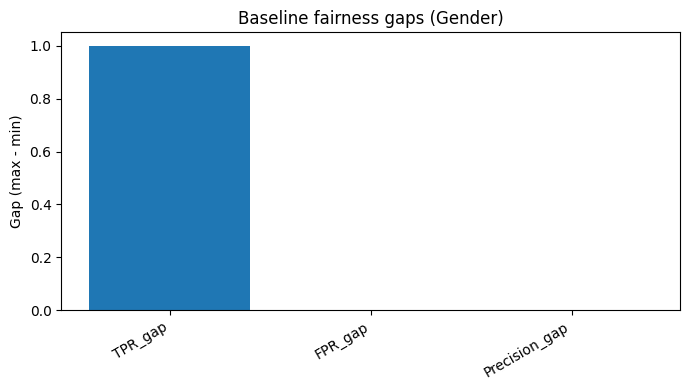

In [12]:
############################################################
# STEP 7: BASELINE MODEL (no mitigation)
############################################################
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

print("Training baseline...")
baseline.fit(X_train, y_train)

proba_test = baseline.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= 0.5).astype(int)

print("\n=== BASELINE PERFORMANCE (Overall) ===")
print(classification_report(y_test, pred_test, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, proba_test), 3))

cm = confusion_matrix(y_test, pred_test)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.title("Baseline Confusion Matrix (threshold=0.5)")
plt.show()

base_rep, base_gaps = fairness_report(y_test, pred_test, g_test, title=f"BASELINE FAIRNESS by {SENSITIVE_COL}")
plot_gap_bar(base_gaps, f"Baseline fairness gaps ({SENSITIVE_COL})")





Group counts: {'Male': 8, 'Female': 6}
Computed group weights: {'Male': 0.875, 'Female': 1.167}

Training reweighted model...

=== REWEIGHTED PERFORMANCE (Overall) ===
              precision    recall  f1-score   support

           0      0.750     1.000     0.857         3
           1      1.000     0.667     0.800         3

    accuracy                          0.833         6
   macro avg      0.875     0.833     0.829         6
weighted avg      0.875     0.833     0.829         6

ROC-AUC: 1.0

=== REWEIGHTED FAIRNESS by Gender ===


,Support,TPR,FPR,Precision
Group,,,,
Female,4,0.0,0.0,NaN
Male,2,1.0,NaN,1.0


Gaps (max-min): {'TPR_gap': 1.0, 'FPR_gap': 0.0, 'Precision_gap': 0.0}


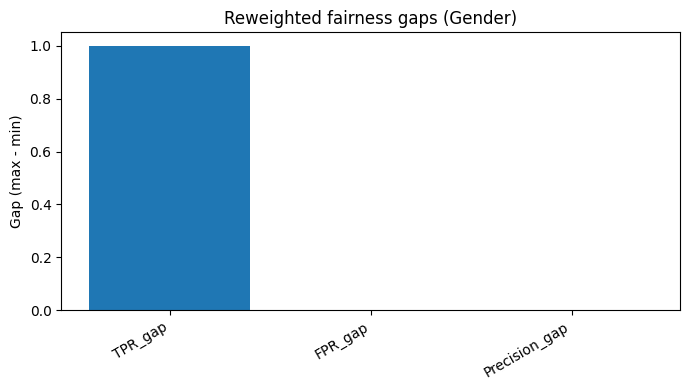

In [13]:
############################################################
# STEP 8: MITIGATION 1 — REWEIGHTING (sample weights)
############################################################
# Idea:
# If one group is underrepresented (or has worse error rates),
# we can upweight its samples during training.
#
# Simple version: weight inversely proportional to group frequency.

group_counts = g_train.value_counts()
group_weights = {g: (len(g_train) / (len(group_counts) * cnt)) for g, cnt in group_counts.items()}
sample_weight = g_train.map(group_weights).values

print("\nGroup counts:", group_counts.to_dict())
print("Computed group weights:", {k: round(v, 3) for k, v in group_weights.items()})

reweighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000))
])

print("\nTraining reweighted model...")
reweighted.fit(X_train, y_train, clf__sample_weight=sample_weight)

proba_rw = reweighted.predict_proba(X_test)[:, 1]
pred_rw = (proba_rw >= 0.5).astype(int)

print("\n=== REWEIGHTED PERFORMANCE (Overall) ===")
print(classification_report(y_test, pred_rw, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, proba_rw), 3))

rw_rep, rw_gaps = fairness_report(y_test, pred_rw, g_test, title=f"REWEIGHTED FAIRNESS by {SENSITIVE_COL}")
plot_gap_bar(rw_gaps, f"Reweighted fairness gaps ({SENSITIVE_COL})")





Target TPR (baseline overall): 0.667
Group thresholds: {'Female': np.float64(0.01), 'Male': np.float64(0.87)}

=== THRESHOLDING PERFORMANCE (Overall) ===
              precision    recall  f1-score   support

           0      0.000     0.000     0.000         3
           1      0.400     0.667     0.500         3

    accuracy                          0.333         6
   macro avg      0.200     0.333     0.250         6
weighted avg      0.200     0.333     0.250         6

ROC-AUC (unchanged): 1.0

=== THRESHOLDING FAIRNESS by Gender ===


,Support,TPR,FPR,Precision
Group,,,,
Female,4,1.0,1.0,0.25
Male,2,0.5,NaN,1.00


Gaps (max-min): {'TPR_gap': 0.5, 'FPR_gap': 0.0, 'Precision_gap': 0.75}


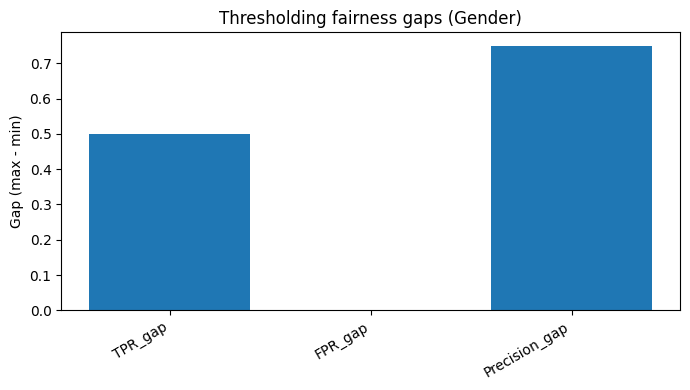

In [14]:
############################################################
# STEP 9: MITIGATION 2 — GROUP THRESHOLDING (post-processing)
############################################################
# Idea:
# Keep the model, but choose a different threshold per group
# to reduce (TPR gap) or enforce some fairness target.
#
# We’ll do a simple approach:
#   Find thresholds per group that try to match a target TPR across groups.

def find_threshold_for_target_tpr(y_true, proba, target_tpr):
    """
    Finds a threshold where TPR is close to target_tpr.
    """
    thresholds = np.linspace(0.01, 0.99, 99)
    best_t = 0.5
    best_dist = 999
    for t in thresholds:
        pred = (proba >= t).astype(int)
        stats = group_confusion_stats(y_true, pred)
        tpr = stats["TPR"]
        if np.isnan(tpr):
            continue
        dist = abs(tpr - target_tpr)
        if dist < best_dist:
            best_dist = dist
            best_t = t
    return best_t

# Choose target TPR = average TPR from baseline at 0.5
# (You could also pick a policy target, e.g. ">=0.70")
overall_base_stats = group_confusion_stats(y_test, pred_test)
target_tpr = overall_base_stats["TPR"]
print("\nTarget TPR (baseline overall):", round(target_tpr, 3))

# Compute per-group thresholds using baseline probabilities
group_thresholds = {}
for g in sorted(g_test.unique()):
    mask = (g_test == g).values
    t = find_threshold_for_target_tpr(y_test.values[mask], proba_test[mask], target_tpr)
    group_thresholds[g] = t

print("Group thresholds:", {k: round(v, 3) for k, v in group_thresholds.items()})

# Apply group thresholds
pred_thr = np.zeros_like(pred_test)
for g in sorted(g_test.unique()):
    mask = (g_test == g).values
    pred_thr[mask] = (proba_test[mask] >= group_thresholds[g]).astype(int)

print("\n=== THRESHOLDING PERFORMANCE (Overall) ===")
print(classification_report(y_test, pred_thr, digits=3))
print("ROC-AUC (unchanged):", round(roc_auc_score(y_test, proba_test), 3))

thr_rep, thr_gaps = fairness_report(y_test, pred_thr, g_test, title=f"THRESHOLDING FAIRNESS by {SENSITIVE_COL}")
plot_gap_bar(thr_gaps, f"Thresholding fairness gaps ({SENSITIVE_COL})")




=== FAIRNESS GAP COMPARISON (lower is better) ===


,Method,TPR_gap,FPR_gap,Precision_gap
0,Baseline(0.5),1.0,0.0,0.00
1,Reweighting(0.5),1.0,0.0,0.00
2,GroupThresholding,0.5,0.0,0.75


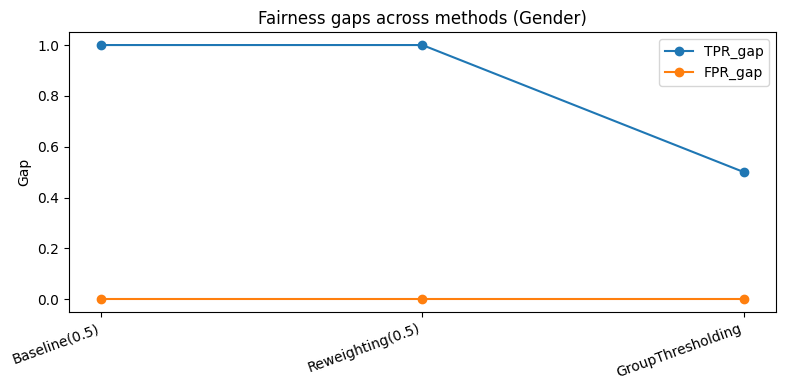

In [15]:

############################################################
# STEP 10: COMPARISON TABLE (Baseline vs Reweighting vs Thresholding)
############################################################
comparison = pd.DataFrame([
    {"Method": "Baseline(0.5)", **base_gaps},
    {"Method": "Reweighting(0.5)", **rw_gaps},
    {"Method": "GroupThresholding", **thr_gaps},
])

print("\n=== FAIRNESS GAP COMPARISON (lower is better) ===")
display(comparison.round(3))

plt.figure(figsize=(8,4))
plt.plot(comparison["Method"], comparison["TPR_gap"], marker="o", label="TPR_gap")
plt.plot(comparison["Method"], comparison["FPR_gap"], marker="o", label="FPR_gap")
plt.title(f"Fairness gaps across methods ({SENSITIVE_COL})")
plt.ylabel("Gap")
plt.xticks(rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()



In [16]:

############################################################
# STEP 11: SUMMARY (what to do next)
############################################################
print("\n=== SUMMARY ===")
print("✓ Baseline trained (with imputation)")
print("✓ Fairness measured by group")
print("✓ Reweighting tested (training-time mitigation)")
print("✓ Group thresholding tested (post-processing mitigation)")
print()
print("NEXT STEPS:")
print("1) Decide fairness goal (TPR parity? FPR parity? equalized odds?)")
print("2) Pick mitigation strategy that meets goal with acceptable performance trade-off")
print("3) Document decision (why this metric, why this threshold, risk analysis)")
print("4) Validate on additional slices (AgeGroup, Hospital Site, intersections)")
print("5) Only then: operationalize (monitor fairness drift in production)")



=== SUMMARY ===
✓ Baseline trained (with imputation)
✓ Fairness measured by group
✓ Reweighting tested (training-time mitigation)
✓ Group thresholding tested (post-processing mitigation)

NEXT STEPS:
1) Decide fairness goal (TPR parity? FPR parity? equalized odds?)
2) Pick mitigation strategy that meets goal with acceptable performance trade-off
3) Document decision (why this metric, why this threshold, risk analysis)
4) Validate on additional slices (AgeGroup, Hospital Site, intersections)
5) Only then: operationalize (monitor fairness drift in production)
